In [1]:
#import datas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
all_data = pd.DataFrame()
df = pd.read_csv('./TrafficLabelling/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

df = pd.read_csv('./TrafficLabelling/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

# df = pd.read_csv('./TrafficLabelling/Friday-WorkingHours-Morning.pcap_ISCX.csv')
# all_data = all_data.append(df, ignore_index=True)

# df = pd.read_csv('./TrafficLabelling/Monday-WorkingHours.pcap_ISCX.csv')
# all_data = all_data.append(df, ignore_index=True)

# df = pd.read_csv('./TrafficLabelling/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
# all_data = all_data.append(df, ignore_index=True)

# df = pd.read_csv('./TrafficLabelling/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
# all_data = all_data.append(df, ignore_index=True)

# df = pd.read_csv('./TrafficLabelling/Tuesday-WorkingHours.pcap_ISCX.csv')
# all_data = all_data.append(df, ignore_index=True)

df = pd.read_csv('./TrafficLabelling/Wednesday-workingHours.pcap_ISCX.csv')
all_data = all_data.append(df, ignore_index=True)

print(all_data.shape)

# print(df.describe())
# print(df)
headers = list(df.columns)
print(headers)

(1204915, 85)
['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN

Remove benigns data such that its 50:50

In [2]:
benigns_to_drop = 1019527
# benigns_to_drop = 1500000
current_row = 0

benigns_index = []

while (benigns_to_drop > 0):
    label = all_data[" Label"][current_row]
    if label == "BENIGN":
        benigns_index.append(current_row)
        benigns_to_drop -= 1
    current_row += 1

all_data = all_data.drop(benigns_index)
all_data = all_data.reset_index(drop = True)

Run this to make label binary (benign or not benign)

In [ ]:
# for i in range(all_data.shape[0]):
#     if all_data[" Label"][i] == "BENIGN":
#         all_data[" Label"][i] = 0
#     else:
#         all_data[" Label"][i] = 1
        
all_data.loc[all_data[' Label'] == "BENIGN", ' Label'] = 0
all_data.loc[all_data[' Label'] != 0, ' Label'] = 1

remove heartbleed

In [7]:
all_data = all_data.drop(all_data[all_data[' Label'] == 'Heartbleed'].index)
all_data = all_data.reset_index(drop = True)

Run to see distribution of labels

In [8]:
output_list = {}
for i in range(all_data.shape[0]):
    label = all_data[" Label"][i]
    if label in output_list:
        output_list[label] = output_list[label] + 1
    else:
        output_list[label] = 1

print(output_list)

{'BENIGN': 665286, 'DDoS': 128027, 'PortScan': 158930, 'DoS slowloris': 5796, 'DoS Slowhttptest': 5499, 'DoS Hulk': 231073, 'DoS GoldenEye': 10293}


In [3]:
total = 0
for key, item in output_list.items():
    if (key != 'BENIGN'):
        total += item
        
print(total)
print(output_list['BENIGN'])

539629
665286


Run to check and fix for infinity or nan values

In [9]:
pd.options.display.max_rows = 4000
pd.options.mode.use_inf_as_na = True
pd.options.mode.use_inf_as_na = True
all_data['Flow Bytes/s'].fillna(all_data['Flow Bytes/s'].max(),inplace=True)
all_data[' Flow Packets/s'].fillna(all_data[' Flow Packets/s'].max(),inplace=True)
all_data.isna().any()

Flow ID                         False
 Source IP                      False
 Source Port                    False
 Destination IP                 False
 Destination Port               False
 Protocol                       False
 Timestamp                      False
 Flow Duration                  False
 Total Fwd Packets              False
 Total Backward Packets         False
Total Length of Fwd Packets     False
 Total Length of Bwd Packets    False
 Fwd Packet Length Max          False
 Fwd Packet Length Min          False
 Fwd Packet Length Mean         False
 Fwd Packet Length Std          False
Bwd Packet Length Max           False
 Bwd Packet Length Min          False
 Bwd Packet Length Mean         False
 Bwd Packet Length Std          False
Flow Bytes/s                    False
 Flow Packets/s                 False
 Flow IAT Mean                  False
 Flow IAT Std                   False
 Flow IAT Max                   False
 Flow IAT Min                   False
Fwd IAT Tota

Run to remove front columns and seperate the features and label into X and y

In [10]:
headers = headers[7:]
headers = np.delete(headers, [-1], 0)
X = all_data.iloc[:, 7:-1].values
y = all_data.iloc[:, -1].values

In [10]:
for i in range(len(headers)):
    print(i, headers[i])

0  Fwd Packet Length Max
1  Fwd Packet Length Min
2 Bwd Packet Length Max
3  ACK Flag Count
4  Avg Bwd Segment Size
5 Init_Win_bytes_forward
6  Init_Win_bytes_backward


Run to remove redundant features

In [10]:
to_be_removed_headers = [5,6,8,9,10,12,16,17,18,21,22,23,26,27,28,37,38,40,41,70,71,72,74,75,76]
headers = np.delete(headers, to_be_removed_headers, 0)
X = np.delete(X, to_be_removed_headers, 1)

Run to select the 7 best features

In [11]:
indices = np.array([5,6,9,46,53,65,66])
idx = indices + 7

headers = [headers[index] for index in indices]
X = all_data.iloc[:, idx].values
y = all_data.iloc[:, -1].values

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# y_train = y_train.astype(int)
# y_test = y_test.astype(int)

In [13]:
model = RandomForestClassifier(n_estimators = 10, criterion = 'gini', max_depth=8 )
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=10)

In [15]:
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, det_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# fpr , fnr, thresholds = det_curve(y_test, y_pred)
# print(fpr)

[[263365   1960     11    602     72      0    109]
 [    89  51114      0     12      0      0      0]
 [  1114      0   2278    690      0      0      0]
 [   379      0    188  91786      0      0      0]
 [   274      0      0      1   1933     53      0]
 [   135      0      0      0    674   1533      0]
 [   243      0      0     18      0      0  63329]]
0.9862561778729444
                  precision    recall  f1-score   support

          BENIGN       0.99      0.99      0.99    266119
            DDoS       0.96      1.00      0.98     51215
   DoS GoldenEye       0.92      0.56      0.69      4082
        DoS Hulk       0.99      0.99      0.99     92353
DoS Slowhttptest       0.72      0.85      0.78      2261
   DoS slowloris       0.97      0.65      0.78      2342
        PortScan       1.00      1.00      1.00     63590

        accuracy                           0.99    481962
       macro avg       0.94      0.86      0.89    481962
    weighted avg       0.99      0

In [17]:
y_pred2 = model.predict(X_train)
cm = confusion_matrix(y_train, y_pred2)
print(cm)
print(accuracy_score(y_train, y_pred2))
print(classification_report(y_train, y_pred2))

# fpr , fnr, thresholds = det_curve(y_test, y_pred)
# print(fpr[1])

[[395030   2940     12    902    131      0    152]
 [   102  76687      0     23      0      0      0]
 [  1677      0   3519   1007      2      6      0]
 [   562      0    302 137856      0      0      0]
 [   399      0      0      0   2753     86      0]
 [   182      0      0      0    957   2315      0]
 [   312      0      1     39      0      0  94988]]
0.9864525784917739
                  precision    recall  f1-score   support

          BENIGN       0.99      0.99      0.99    399167
            DDoS       0.96      1.00      0.98     76812
   DoS GoldenEye       0.92      0.57      0.70      6211
        DoS Hulk       0.99      0.99      0.99    138720
DoS Slowhttptest       0.72      0.85      0.78      3238
   DoS slowloris       0.96      0.67      0.79      3454
        PortScan       1.00      1.00      1.00     95340

        accuracy                           0.99    722942
       macro avg       0.93      0.87      0.89    722942
    weighted avg       0.99      0

[1 1 1 1 1 1 1]
7
feature:  Fwd Packet Length Max, value: 0.15227
feature:  Fwd Packet Length Min, value: 0.07447
feature: Bwd Packet Length Max, value: 0.14516
feature:  ACK Flag Count, value: 0.04962
feature:  Avg Bwd Segment Size, value: 0.19713
feature: Init_Win_bytes_forward, value: 0.22941
feature:  Init_Win_bytes_backward, value: 0.15195


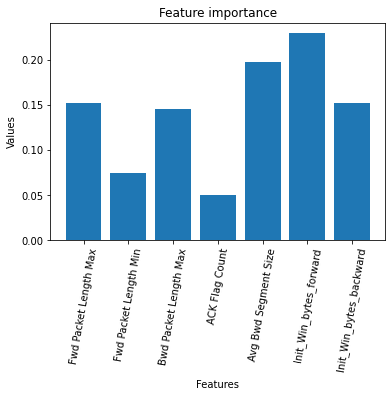

In [23]:
features = model.feature_importances_

refined_features = np.where(features > 0.04, 1, 0)
print(refined_features)
print(np.count_nonzero(refined_features))

for i,v in enumerate(features):
    if (v != 0):
        print('feature: %s, value: %.5f' % (headers[i],v))

plt.bar(headers, model.feature_importances_)
plt.title('Feature importance')
plt.xlabel('Features')
plt.ylabel('Values')
plt.xticks(rotation=80)
plt.show()

In [34]:
np.argmax(model.feature_importances_)

46

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
accuracy = []
accuracy_train = []
for i in range(2,15):
    model = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred2 = model.predict(X_train)
    accuracy.append(accuracy_score(y_test, y_pred))
    accuracy_train.append(accuracy_score(y_train, y_pred2))

max_depth: 0, Score: 0.85556
max_depth: 1, Score: 0.91028
max_depth: 2, Score: 0.94823
max_depth: 3, Score: 0.96914
max_depth: 4, Score: 0.97133
max_depth: 5, Score: 0.97672
max_depth: 6, Score: 0.98655
max_depth: 7, Score: 0.99025
max_depth: 8, Score: 0.99162
max_depth: 9, Score: 0.99218
max_depth: 10, Score: 0.99233
max_depth: 11, Score: 0.99247
max_depth: 12, Score: 0.99249


max_depth: 0, Score: 0.85491
max_depth: 1, Score: 0.90925
max_depth: 2, Score: 0.94773
max_depth: 3, Score: 0.96914
max_depth: 4, Score: 0.97104
max_depth: 5, Score: 0.97662
max_depth: 6, Score: 0.98675
max_depth: 7, Score: 0.99054
max_depth: 8, Score: 0.99191
max_depth: 9, Score: 0.99244
max_depth: 10, Score: 0.99252
max_depth: 11, Score: 0.99270
max_depth: 12, Score: 0.99270


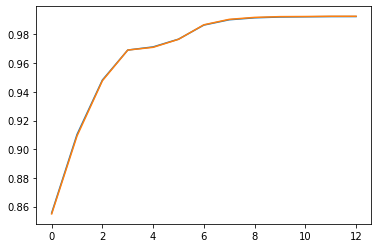

In [20]:
for i,v in enumerate(accuracy):
    print('max_depth: %0d, Score: %.5f' % (i,v))

print("\n")
    
for i,v in enumerate(accuracy_train):
    print('max_depth: %0d, Score: %.5f' % (i,v))

plt.plot([x for x in range(len(accuracy))], accuracy, accuracy_train)
# plt.plot([x for x in range(len(accuracy_train))], accuracy_train)
plt.show()

max_depth: 0, Score: 0.50041
max_depth: 1, Score: 0.50042
max_depth: 2, Score: 0.76431
max_depth: 3, Score: 0.71826
max_depth: 4, Score: 0.76284
max_depth: 5, Score: 0.78475
max_depth: 6, Score: 0.77749
max_depth: 7, Score: 0.85641
max_depth: 8, Score: 0.90303
max_depth: 9, Score: 0.91039
max_depth: 10, Score: 0.93333
max_depth: 11, Score: 0.94976
max_depth: 12, Score: 0.95855
max_depth: 13, Score: 0.96293


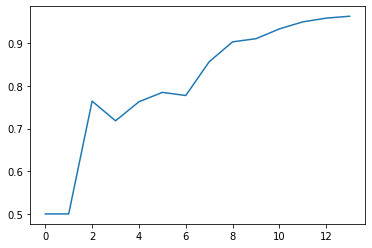

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
accuracy = []
for i in range(1,15):
    model = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', class_weight={0:1,1:200000}, max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    
for i,v in enumerate(accuracy):
    print('max_depth: %0d, Score: %.5f' % (i,v))

plt.plot([x for x in range(len(accuracy))], accuracy)
plt.show()